In [ ]:
# #hide
# !pip install fastai==2.1.5
# !pip install fastai2==0.0.30
# !pip install fastcore==1.3.5

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!ls

     |████████████████████████████████| 727kB 13.2MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 1.1MB 52.3MB/s 
     |████████████████████████████████| 194kB 46.7MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
import pandas as pd
from fastai.data.all import *
from fastai.vision.all import *
import fastai
import os
from PIL import Image
from google.colab import drive

# drive.mount('/content/gdrive')
# # os.system('cd gdrive/My\ Drive/Colab\ Notebooks/Capstone3')
# # os.getcwd()
# !ls

## For the first step, we will import our authentication for the Kaggle API.

In [ ]:
from google.colab import files

! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list


Saving kaggle.json to kaggle.json


Step 1: Data Wragnling
Here we will directly use a set of data coming from Kaggle by applying the URL

In [ ]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip \*.zip  && rm *.zip
os.chdir('real_and_fake_face')
!ls

 96% 414M/431M [00:02<00:00, 147MB/s]
100% 431M/431M [00:02<00:00, 181MB/s]
Archive:  real-and-fake-face-detection.zip
  inflating: real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_111_1101.jpg  
  inflating: real_and_fa

# Check if the Image are downloaded correctly

mid_191_0111.jpg


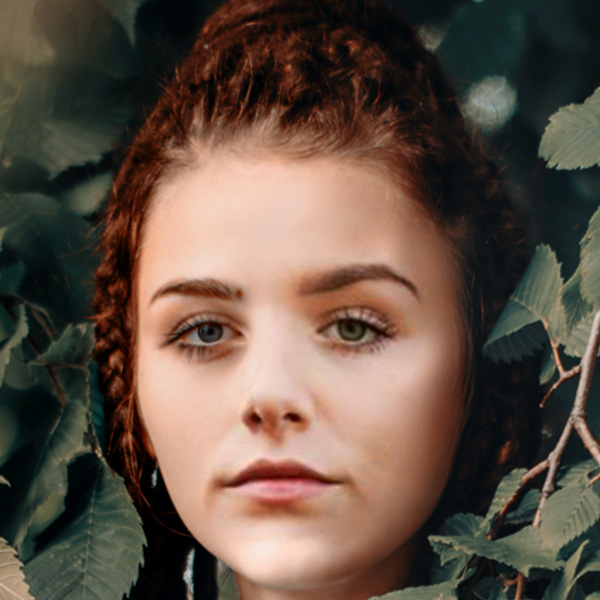

In [ ]:
fake_fns = get_image_files('training_fake')
image_path = os.getcwd()/fake_fns[0]
im = Image.open(image_path)
print(os.listdir('training_fake')[0])
im

real_00108.jpg


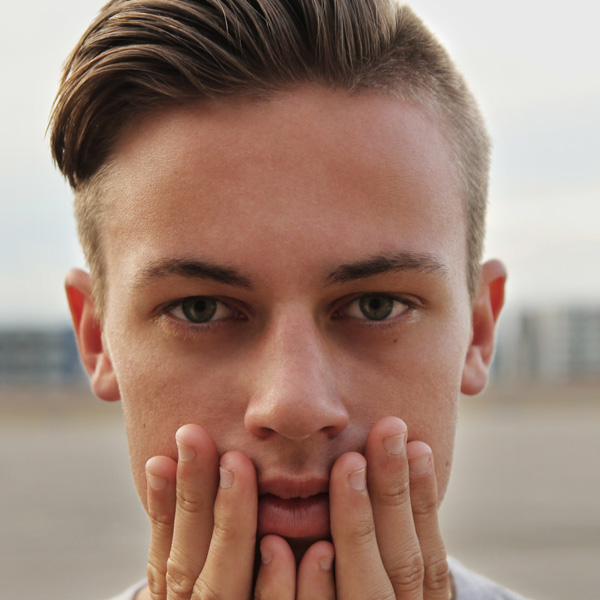

In [ ]:
real_fns = get_image_files('training_real')
image_path = os.getcwd()/real_fns[0]
im = Image.open(image_path)
print(os.listdir('training_real')[0])
im

The picture looks reasonable. Let us make a data loader

In [ ]:
faces = DataBlock(blocks=(ImageBlock, CategoryBlock),
          get_items = get_image_files,
          splitter = RandomSplitter(valid_pct= 0.2, seed = 42),
          get_y=parent_label,
          item_tfms = Resize(128))
#get_image files get all the image from certain path
#parent label = use parent's folder name as your label

# Generate dataloader and provide data augmentation

We have generate a template for our datablock let see if we can enter some data in it.  Since Fastai combine the data augmentation, within the datablock.  We will apply that as well and evaluate how well it works!

**DataLoader vs DataSet in pyTorch**.  Data loader fetches data from a data set and serves the data up in batches, while datasets loads the traing or test data into memory

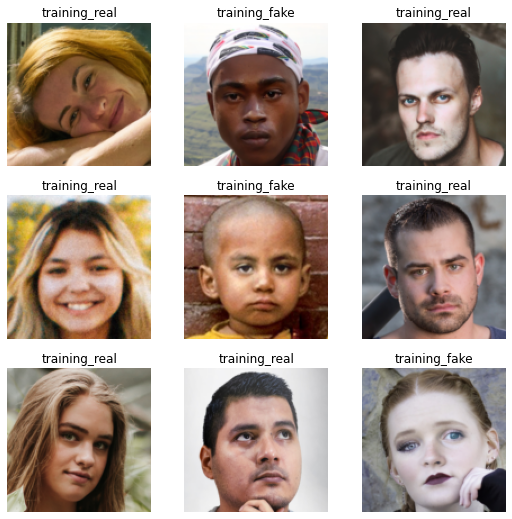

In [ ]:
image_path = os.getcwd()
dls = faces.dataloaders(image_path)
dls.show_batch()

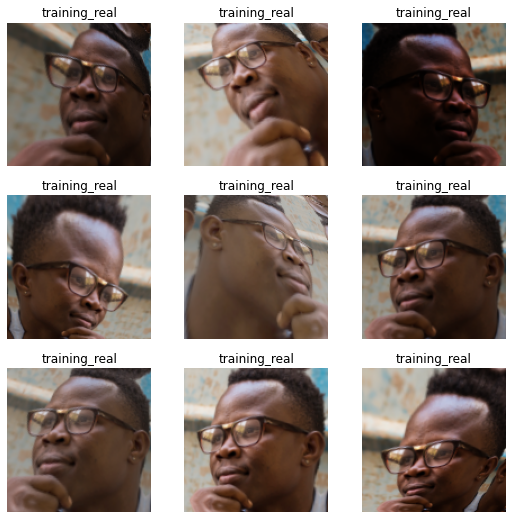

In [ ]:
faces = faces.new(item_tfms=Resize(128), batch_tfms =aug_transforms(mult=2) )
dls = faces.dataloaders(image_path)
dls.show_batch(unique= True)

# Model Generation

For the model, we will pick existing models avaliable from Fastai, which includes:


* resnet18, resnet34, resnet50, resnet101, resnet152
* squeezenet1_0, squeezenet1_1
* densenet121, densenet169, densenet201, densenet161
* vgg16_bn, vgg19_bn
* alexnet

## In this situation, we will try out resnet34


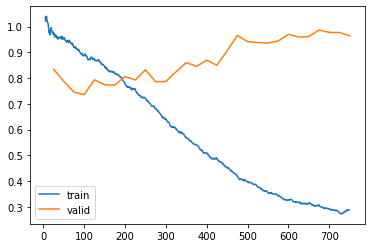

In [ ]:
import torchvision.models as models
#model = create_cnn_model(models.mobilenet_v2, n_out=2, cut = -1,pretrained=True)
#learn = Learner(dls, model , metrics=error_rate)

learn = cnn_learner(dls, resnet34,metrics=error_rate )
learn.fine_tune(30, base_lr=1e-3, freeze_epochs=3)
learn.recorder.plot_loss()

# Here, We will see if we can get the intermediate layer

Note:  Learner.summary() is currently bugged out!


Explaination: The problem is that now TensorBase.shape is returning a tuple instead of torch.Size. Not sure whats the best way to solve this, a change on TensorBase.__torch_function__ is now using torch.tensor._convert which is turning the result into a tuple:


In [ ]:
# going to try to extract the intermediate layer.  


image_path = os.getcwd()/fake_fns[150]
x, = first(dls.test_dl([image_path]))


In [ ]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

with torch.no_grad(): output = learn.model.eval()(x)
act = hook_output.stored[0]
F.softmax(output,dim = -1)

tensor([[9.9908e-01, 9.1809e-04]], device='cuda:0')

In [ ]:
dls.vocab

['training_fake', 'training_real']

In [ ]:
x.shape


(1, 3, 128, 128)

In [ ]:
#learn.model[0]
#learn.model[1][-1].weight.shape
#act.shape
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 4, 4])

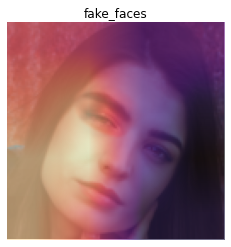

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.set_title('fake_faces')
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,128,128,0),
              interpolation='bilinear', cmap='magma');


## Learn rate and Classification result


SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=1.5848931980144698e-06)

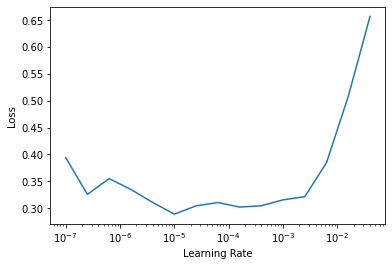

In [ ]:
learn.lr_find(stop_div=False, num_it=20)
# it doesn't look like learning rate matter that much in this situation.  we will use default of 1E-2

Since our model already going through the fine tune cycle.  The Learn Rate finder is not as important.  However, it is recommended that you pick a LR 10 fold lower than the curve that beginning to ascend.  (Here you probably want something 10e-4 < lr < 10e-3, which default is 0.001)

<bound method ClassificationInterpretation.confusion_matrix of <fastai.interpret.ClassificationInterpretation object at 0x7fe18ea59a20>>

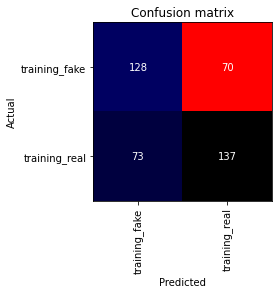

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(cmap = 'flag')
interp.confusion_matrix

The confusion matrix looks ok.  We have an accuracy around 65 percent.  We can now look at the data that are predict incorrectly with maximum loss and see if we can find there is any reasons why some of these face a predicted incorrectly

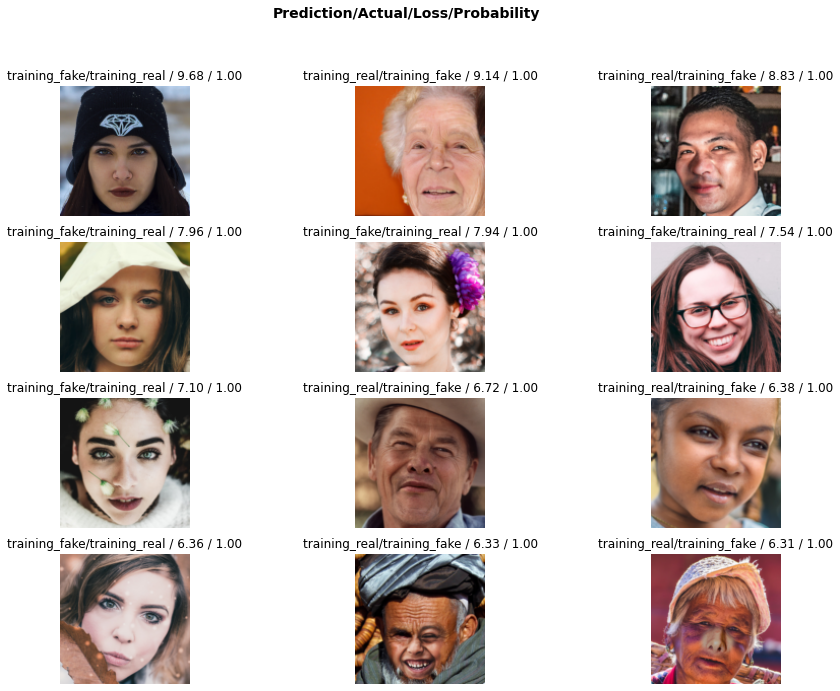

In [ ]:
interp.plot_top_losses(12 ,nrows =4, figsize=(15,11))

I am not sure if there is a pattern here.

## Here is a function that combines everything above and make a function that  does all the testing together

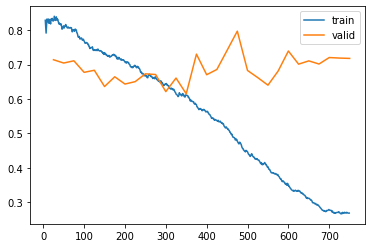

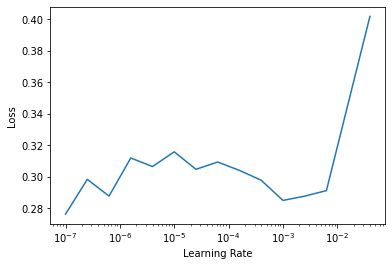

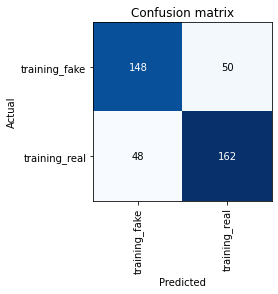

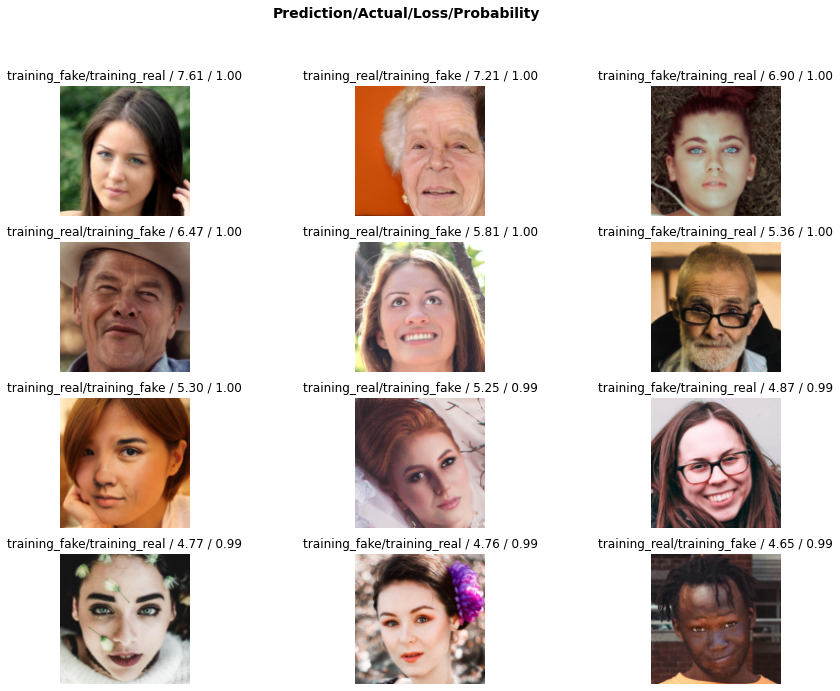

In [ ]:
# Here it is important to make a custom head so that your last linear layer has same amount of input features with the output features from your transfer learning model

head = nn.Sequential(
    AdaptiveConcatPool2d(),
    Flatten(full=False),
    nn.Linear(2560, out_features=256,bias = True),
    nn.ReLU(inplace=True),
    BatchNorm(256, ndim= 1 ),
    nn.Dropout(0.4, inplace=True),
    nn.Linear(256, out_features=64,bias = False),
    nn.ReLU(inplace=True),
    BatchNorm(64, ndim= 1 ),
    nn.Linear(64, out_features=1280,bias = False),
    nn.ReLU(inplace=True),
    BatchNorm(1280, ndim= 1 ),
    nn.Dropout(0.3, inplace=True),
    nn.Linear(1280, out_features=2, bias = False),
)
model = create_cnn_model(models.mobilenet_v2, n_out=2, cut = -1,pretrained=True,custom_head=head)

def model_ft(dls = dls, model = model, ft_cycle = 3 , base_lr = 1e-3):
  learn = Learner(dls, model , metrics=error_rate)
  #learn = cnn_learner(dls, resnet34,metrics=error_rate )
  learn.fine_tune(ft_cycle, base_lr=base_lr, freeze_epochs=3)
  learn.recorder.plot_loss()

  learn.lr_find(stop_div=False, num_it=20)
  interp = ClassificationInterpretation.from_learner(learn)
  interp.plot_confusion_matrix()
  interp.plot_top_losses(12 ,nrows =4, figsize=(15,11))
  return learn

learn = model_ft(dls, model, ft_cycle = 30 )



## We will now automate the process to show the last activation layer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: This function is deprecated. Please call randint(0, 960 + 1) instead


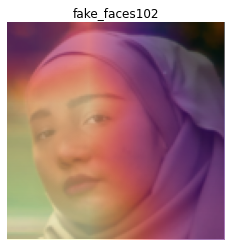

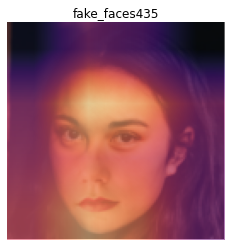

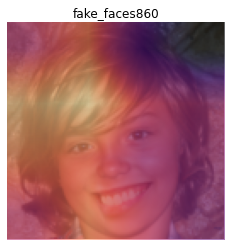

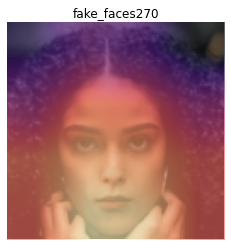

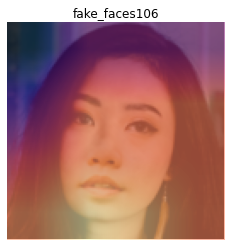

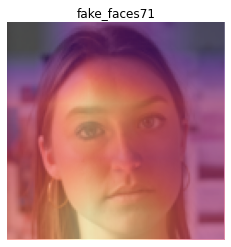

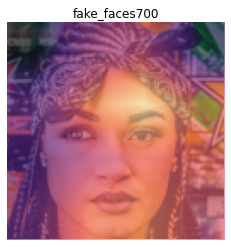

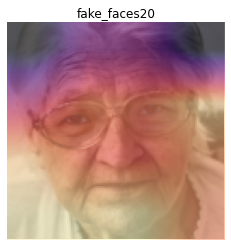

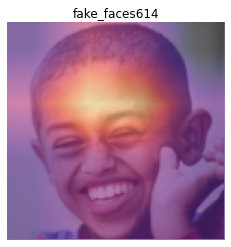

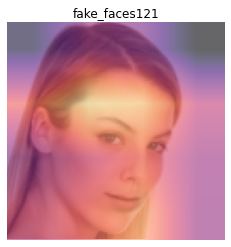

In [ ]:
def auto_activ_view(dls,learn, index_list, title):
  for i in index_list:
    image_path = os.getcwd()/fake_fns[i]
    x, = first(dls.test_dl([image_path]))

    hook_output = Hook()
    hook = learn.model[0].register_forward_hook(hook_output.hook_func)

    with torch.no_grad(): output = learn.model.eval()(x)
    act = hook_output.stored[0]
    #print(F.softmax(output,dim = -1))
    #print(dls.vocab)
    #print('learn model weight shape is:', learn.model[1][-1].weight.shape)
    #print('activation shape is:', act.shape)

    cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
    cam_map.shape


    x_dec = TensorImage(dls.train.decode((x,))[0][0])
    _,ax = plt.subplots()
    ax.set_title(title + str(i))
    x_dec.show(ctx=ax)
    ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,128,128,0),
                  interpolation='bilinear', cmap='magma');

random_index = np.random.random_integers(0,len(fake_fns),10)
auto_activ_view(dls, learn, random_index, 'fake_faces')

In [ ]:
head = nn.Sequential(
    AdaptiveConcatPool2d(),
    Flatten(full=False),
    nn.Linear(2560, out_features=256,bias = True),
    nn.ReLU(inplace=True),
    BatchNorm(256, ndim= 1 ),
    nn.Dropout(0.4, inplace=True),
    nn.Linear(256, out_features=64,bias = False),
    nn.ReLU(inplace=True),
    BatchNorm(64, ndim= 1 ),
    nn.Dropout(0.1, inplace=True),
    nn.Linear(64, out_features=2, bias = False),
    nn.Softmax(dim=1)
)

#act.shape[0]
model = create_cnn_model(models.mobilenet_v2, n_out=2, cut = -1, custom_head= head ,pretrained=True)

#models.resnet34()
# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
# cam_map.shape

Ok, now, we will use a custom head (or convolution/classifcation layers) for and see if we can get some improvement on our model

In [ ]:
import shutil

def make_wking_folder(difficulty):
  #difficulty = easy, mid, or hard
  shutil.rmtree('wking_folder', ignore_errors = True)
  os.mkdir('wking_folder')
  os.mkdir('wking_folder/' + difficulty + '_train')
  working_directory  = 'wking_folder/' + difficulty + '_train'
  for f in os.listdir('training_fake'):
    if f.startswith(difficulty):
      shutil.copyfile('training_fake/'+ f, working_directory+ '/' + f)
  shutil.copytree('training_real', 'wking_folder/' + 'training_real')

make_wking_folder('easy')


In [ ]:
def training_models():
  faces = DataBlock(blocks=(ImageBlock, CategoryBlock),
            get_items = get_image_files,
            splitter = RandomSplitter(valid_pct= 0.2, seed = 42),
            get_y=parent_label,
            item_tfms = Resize(128))
  image_path = os.getcwd() + '/wking_folder'
  dls = faces.dataloaders(image_path)
  dls.show_batch()
  learn = Learner(dls, models.mobilenet_v2(pretrained=True)  , metrics=error_rate)
  learn.fine_tune(30)

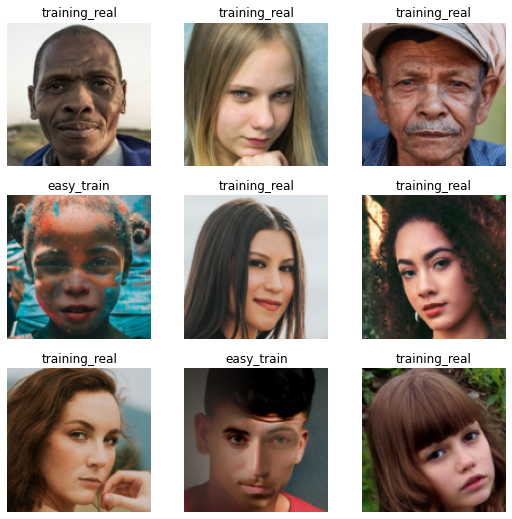

In [ ]:
make_wking_folder('easy')
training_models()

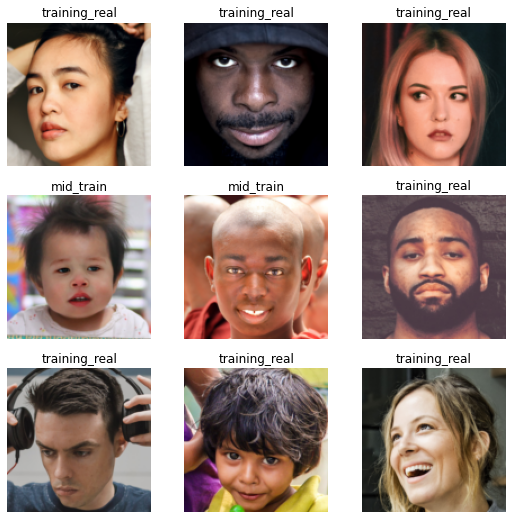

In [ ]:
make_wking_folder('mid')
training_models()

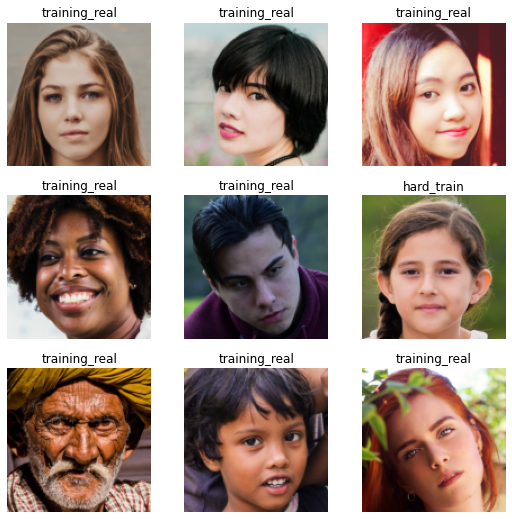

In [ ]:
make_wking_folder('hard')
training_models()

We will take out the model and use it to make an apps

In [ ]:
learn.export('real_fake_face.pkl')
path = Path()
path.ls(file_exts='.pkl')
!ls ..

kaggle.json  real_and_fake_face		   training_fake  wking_folder
models	     real_and_fake_face_detection  training_real


In [ ]:
shutil.copyfile('real_fake_face.pkl','/content/gdrive/MyDrive/Colab Notebooks/Capstone3/real_fake_face.pkl')
!ls ../gdrive/MyDrive/Colab\ Notebooks/Capstone3

ls: cannot access '../gdrive/MyDrive/Colab Notebooks/Capstone3': No such file or directory
